In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
import plotly.graph_objects as go
import plotly.io as pio

# Configurar el renderizador de Plotly
pio.renderers.default = 'browser'
df = pd.read_csv("dataset.csv")

# Inspeccionar los datos
print(df.head())
print(df.info())


        Fecha             Hora   Categoría Ubicación           Género  \
0  2020-01-01         00:00:00     Zapatos  Tienda C  No especificado   
1  2020-01-01  10:57:31.462865   Camisetas  Tienda C  No especificado   
2  2020-01-01  21:55:02.925731     Zapatos  Tienda A         Femenino   
3  2020-01-02  08:52:34.388597  Accesorios  Tienda A         Femenino   
4  2020-01-02  19:50:05.851462     Zapatos  Tienda B  No especificado   

   Código Cliente  Cliente Recurrente    Proveedor    Nombre del producto  \
0            1091                   0  Proveedor A      Botas de Invierno   
1            1081                   0  Proveedor B        Camiseta Casual   
2            1065                   0  Proveedor D       Zapatos Formales   
3            1060                   0  Proveedor B                  Gorra   
4            1087                   0  Proveedor B  Zapatillas Deportivas   

           Marca  Precio unitario  Cantidad_vendida  Ingresos  CompraAlta  \
0     Timberland     

In [59]:
# Verifica las columnas del DataFrame
print(df.columns)

# Verifica si las columnas 'Categoría', 'Ubicación', 'Género', 'Marca', 'Proveedor' están presentes
columnas_a_comprobar = ['Categoría', 'Ubicación', 'Género', 'Marca', 'Proveedor']
columnas_existentes = [col for col in columnas_a_comprobar if col in df.columns]

print("Columnas existentes en el DataFrame:", columnas_existentes)

# Si existen, procede a codificarlas, sino solo codifica las que están disponibles
if columnas_existentes:
    df = pd.get_dummies(df, columns=columnas_existentes, drop_first=True)
else:
    print("No se encontraron las columnas especificadas para codificar.")



Index(['Fecha', 'Hora', 'Categoría', 'Ubicación', 'Género', 'Código Cliente',
       'Cliente Recurrente', 'Proveedor', 'Nombre del producto', 'Marca',
       'Precio unitario', 'Cantidad_vendida', 'Ingresos', 'CompraAlta',
       'Categoría_num', 'Ubicación_num', 'Género_num'],
      dtype='object')
Columnas existentes en el DataFrame: ['Categoría', 'Ubicación', 'Género', 'Marca', 'Proveedor']


In [60]:
# Convertir 'Fecha' al tipo datetime explícitamente
df['Fecha'] = pd.to_datetime(df['Fecha'], errors='coerce')

# Verificar si hay valores NaT (valores que no se pudieron convertir)
if df['Fecha'].isna().any():
    print("Advertencia: Algunos valores en la columna 'Fecha' no se pudieron convertir a datetime:")
    print(df[df['Fecha'].isna()])

# Continuar con la extracción del mes si no hay problemas
df['Mes'] = df['Fecha'].dt.month

# Verificar los tipos de datos de todas las columnas
print("Tipos de datos en el DataFrame:")
print(df.dtypes)

# Seleccionar solo las características numéricas para X
X = df.select_dtypes(include=[float, int])  # Solo columnas numéricas

# Verificar las primeras filas de las columnas numéricas
print("Primeras filas de X:")
print(X.head())

# Verificar si hay columnas con valores NaN
nan_columns = X.columns[X.isna().any()].tolist()
if len(nan_columns) > 0:
    print(f"Columnas con valores NaN: {nan_columns}")
    print("Valores NaN por columna:")
    print(X[nan_columns].isna().sum())

# Rellenar los valores faltantes con la media de cada columna
X = X.fillna(X.mean())

# Verificar columnas completamente vacías
columnas_vacias = X.columns[X.isna().all()]
if len(columnas_vacias) > 0:
    print(f"Columnas completamente vacías: {columnas_vacias}")
    X = X.drop(columns=columnas_vacias)

# Rellenar valores NaN restantes con un valor fijo si es necesario
X = X.fillna(0)  # O usa X.fillna(X.median())

# Reemplazar infinitos con el valor máximo de la columna correspondiente
for column in X.columns:
    X[column] = X[column].replace([float('inf'), -float('inf')], X[column].max())
    X[column] = X[column].fillna(X[column].max())

# Verificar si todavía hay NaN o Inf
assert not X.isna().values.any(), "¡Aún hay valores NaN en X después de la limpieza!"
assert not (X == float('inf')).values.any(), "¡Aún hay valores infinitos en X después de limpiar!"

# Eliminar columnas con desviación estándar cero (ya que no se pueden normalizar)
X = X.loc[:, X.std() != 0]

# Normalización de las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Análisis exploratorio ---
# Productos más vendidos
productos_mas_vendidos = df.groupby('Nombre del producto')['Cantidad_vendida'].sum().sort_values(ascending=False)

# Mostrar los productos más vendidos
print("Top 5 productos más vendidos:")
print(productos_mas_vendidos.head())

# Calcular los ingresos por mes
ingresos_por_mes = df.groupby('Mes')['Ingresos'].sum()

# Crear gráfico interactivo con Plotly
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=ingresos_por_mes.index,
    y=ingresos_por_mes.values,
    mode='lines+markers',
    marker=dict(symbol='circle', size=8, color='blue'),
))

fig.update_layout(
    title='Ingresos por Mes',
    xaxis=dict(
        title='Mes',
        tickmode='array',
        tickvals=ingresos_por_mes.index,
        ticktext=['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre'],
    ),
    yaxis=dict(title='Ingresos'),
    template='plotly',
    showlegend=False,
    xaxis_showgrid=True,
    yaxis_showgrid=True,
)

# Mostrar el gráfico
fig.show()


Tipos de datos en el DataFrame:
Fecha                     datetime64[ns]
Hora                              object
Código Cliente                     int64
Cliente Recurrente                 int64
Nombre del producto               object
Precio unitario                    int64
Cantidad_vendida                   int64
Ingresos                           int64
CompraAlta                         int64
Categoría_num                      int64
Ubicación_num                      int64
Género_num                         int64
Categoría_Accesorios                bool
Categoría_Camisetas                 bool
Categoría_Pantalones                bool
Categoría_Zapatos                   bool
Ubicación_Tienda A                  bool
Ubicación_Tienda B                  bool
Ubicación_Tienda C                  bool
Género_Masculino                    bool
Género_No especificado              bool
Marca_Allen Edmonds                 bool
Marca_Ascender                      bool
Marca_Canada Goose       

In [61]:
X = df[['Mes', 'Ingresos']]  # Ejemplo de características
y = df['Cantidad_vendida']   # Ventas como salida

# Dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizar características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# --- Construcción de la red neuronal ---
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)  # Una salida para proyección de ventas
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# --- Entrenamiento ---
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# --- Evaluación ---
loss, mae = model.evaluate(X_test, y_test, verbose=1)
print(f"Mean Absolute Error en prueba: {mae}")

# --- Predicciones ---
y_pred = model.predict(X_test)

# Mostrar algunas predicciones
print("Predicciones vs Reales:")
print(pd.DataFrame({'Predicción': y_pred.flatten(), 'Real': y_test}).head())

Epoch 1/100


C:\Users\jrios\Desktop\IA\env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 25.3062 - mae: 4.3255 - val_loss: 8.1052 - val_mae: 2.3129
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.8154 - mae: 2.1526 - val_loss: 6.3073 - val_mae: 2.0800
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.7831 - mae: 1.9909 - val_loss: 5.5249 - val_mae: 1.9537
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.0768 - mae: 1.8767 - val_loss: 4.9694 - val_mae: 1.8712
Epoch 5/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.7848 - mae: 1.8358 - val_loss: 4.7255 - val_mae: 1.7996
Epoch 6/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.2410 - mae: 1.7232 - val_loss: 4.4324 - val_mae: 1.7665
Epoch 7/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.0442 - mae: 1.6862 - val_loss: 4.1589 - val_mae: 1.6947
Epoch 8/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.9448 - mae: 1.6509 - val_loss: 4.0655 - val_mae: 1.6645
Epoch 9/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.8130 - mae: 1.

No hay datos faltantes en el DataFrame.


<Figure size 1000x600 with 0 Axes>

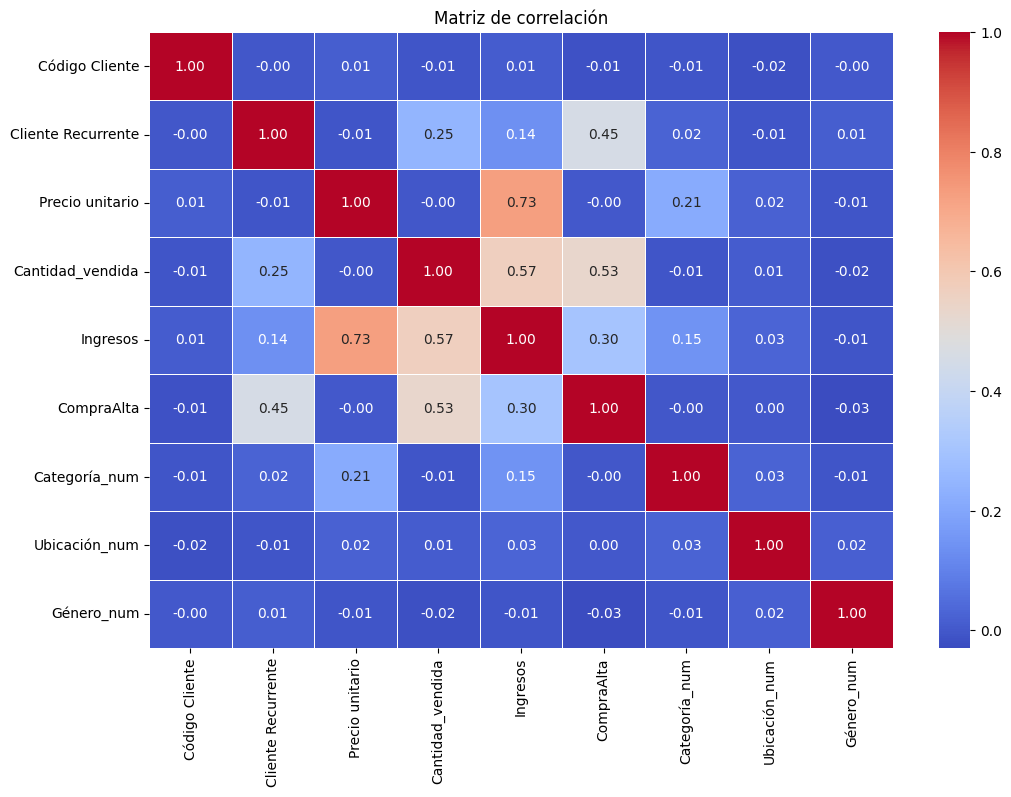

Epoch 1/100


C:\Users\jrios\Desktop\IA\env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 71701.4766 - mae: 196.3329 - val_loss: 66197.8359 - val_mae: 188.9844
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 66334.5469 - mae: 186.3310 - val_loss: 52334.0391 - val_mae: 162.0096
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 47756.8203 - mae: 154.7040 - val_loss: 25157.5527 - val_mae: 102.1815
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18798.3750 - mae: 86.4489 - val_loss: 6142.8335 - val_mae: 50.0513
Epoch 5/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4589.2402 - mae: 44.2678 - val_loss: 3128.2812 - val_mae: 38.7933
Epoch 6/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2856.6062 - mae: 35.9079 - val_loss: 2620.0581 - val_mae: 36.4336
Epoch 7/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2381.0686 - mae: 33.4578 - val_loss: 2348.2031 - val_mae: 35.2033
Epoch 8/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2087.8252 - mae: 31.8835 - val_loss: 2208.9873 - val_mae: 34.8210

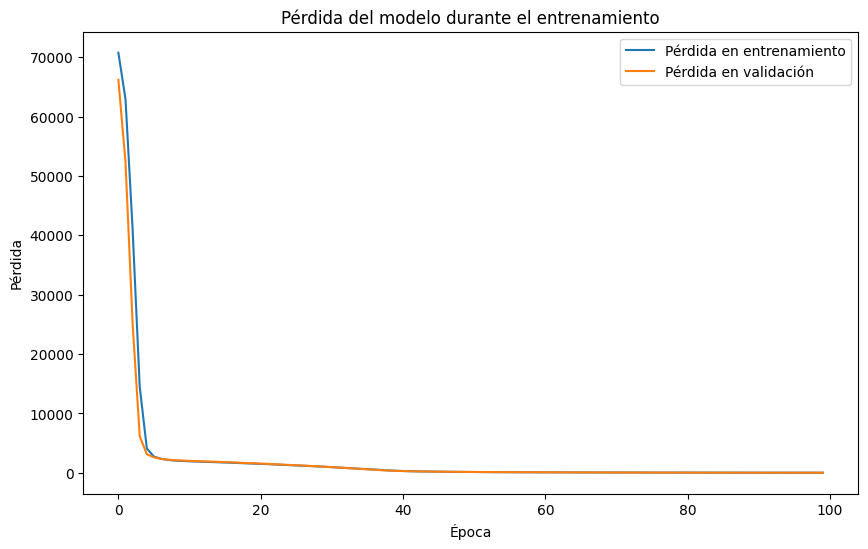

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
   Predicción  Real
0   76.472595    80
1  356.598114   360
2  133.225174   140
3  223.885742   225
4  318.559204   315
Valores únicos en 'Ubicación': ['Tienda C' 'Tienda A' 'Tienda B' 'Online']
Proyección de ventas por tienda:
Ubicación
Tienda B    206106
Tienda C    199084
Tienda A    189876
Online      185974
Name: Ingresos, dtype: int64


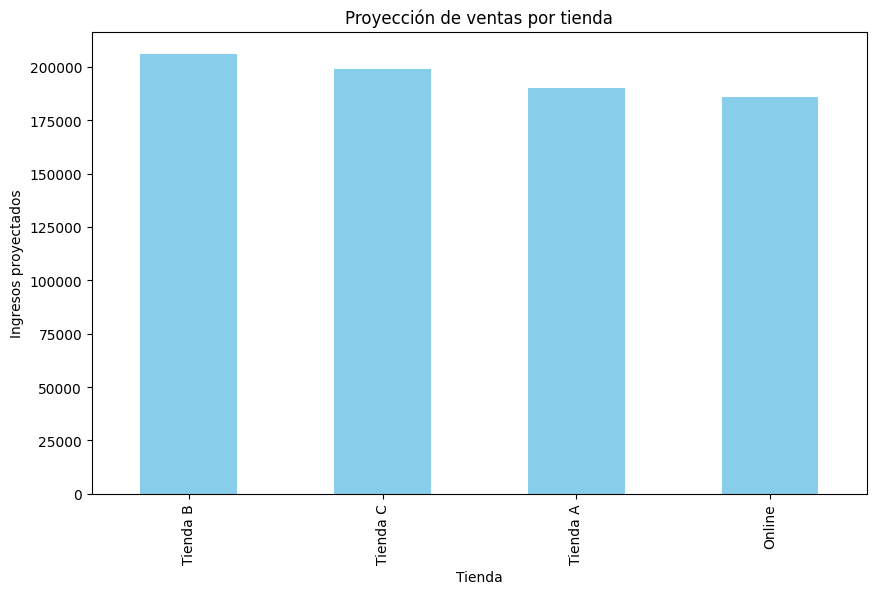

In [73]:
# --- Visualización de pérdida de datos ---
plt.figure(figsize=(10, 6))
missing_data = df.isnull().sum()
missing_data = missing_data[missing_data > 0]

if not missing_data.empty:  # Verificar si hay datos faltantes
    missing_data.sort_values().plot(kind='barh', color='skyblue')
    plt.title('Pérdida de datos por columna')
    plt.xlabel('Número de valores nulos')
    plt.ylabel('Columnas')
    plt.show()
else:
    print("No hay datos faltantes en el DataFrame.")

# --- Matriz de correlación ---
# Seleccionamos solo las columnas numéricas para calcular la correlación
numeric_df = df.select_dtypes(include=[float, int])

# Calcular la matriz de correlación
plt.figure(figsize=(12, 8))
correlation_matrix = numeric_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de correlación')
plt.show()

# --- Configuración de datos para red neuronal ---
# Seleccionar características numéricas y objetivo
X = df[['Categoría_num', 'Ubicación_num', 'Género_num', 'Precio unitario', 'Cantidad_vendida']]
y = df['Ingresos']  # Asumimos que quieres predecir ingresos por tienda

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalización de características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# --- Crear la red neuronal ---
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')  # Salida continua
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# --- Entrenamiento ---
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# --- Evaluación del modelo ---
loss, mae = model.evaluate(X_test, y_test, verbose=1)
print(f"Mean Absolute Error en prueba: {mae}")

# --- Visualización del entrenamiento ---
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida del modelo durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

# --- Predicción de ventas ---
y_pred = model.predict(X_test)
resultados = pd.DataFrame({'Predicción': y_pred.flatten(), 'Real': y_test.values})
print(resultados.head())

# Verificar y limpiar nombres de columnas
df = pd.read_csv("dataset.csv")
df.columns = df.columns.str.strip()

# Verificar si existe 'Ubicación'
if 'Ubicación' not in df.columns:
    raise KeyError("La columna 'Ubicación' no se encuentra en el DataFrame.")

# Verificar contenido de 'Ubicación'
print("Valores únicos en 'Ubicación':", df['Ubicación'].unique())

# Agrupamiento por ubicación
df_ubicaciones = df.groupby('Ubicación')['Ingresos'].sum().sort_values(ascending=False)
print("Proyección de ventas por tienda:")
print(df_ubicaciones)

# Visualización
plt.figure(figsize=(10, 6))
df_ubicaciones.plot(kind='bar', color='skyblue')
plt.title('Proyección de ventas por tienda')
plt.xlabel('Tienda')
plt.ylabel('Ingresos proyectados')
plt.show()



Correlación entre variables predictoras y 'Ingresos':
                  Precio unitario  Cantidad_vendida  Ingresos
Precio unitario          1.000000         -0.004223  0.729152
Cantidad_vendida        -0.004223          1.000000  0.568004
Ingresos                 0.729152          0.568004  1.000000
Duplicados entre entrenamiento y prueba: 1628
Error absoluto medio (MAE) del árbol de decisión: 0.0
MAE promedio en validación cruzada: 21.470499999999998


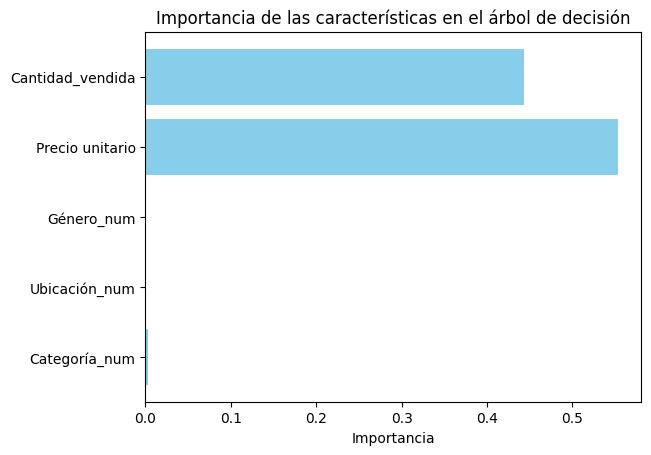

      Real  Predicción
555     80        80.0
3491   360       360.0
527    140       140.0
3925   225       225.0
2989   315       315.0


In [74]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
import pandas as pd
import matplotlib.pyplot as plt

# --- Asegurarse de que los nombres de columnas no tengan espacios adicionales ---
df.columns = df.columns.str.strip()

# --- Confirmar que las variables predictoras no incluyan la fórmula exacta de 'Ingresos' ---
X = df[['Categoría_num', 'Ubicación_num', 'Género_num', 'Precio unitario', 'Cantidad_vendida']]
y = df['Ingresos']

# Verificar correlaciones para identificar relaciones directas
print("Correlación entre variables predictoras y 'Ingresos':")
print(df[['Precio unitario', 'Cantidad_vendida', 'Ingresos']].corr())

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verificar que no haya duplicados entre los conjuntos de entrenamiento y prueba
duplicates = X_train.merge(X_test, how='inner')
print(f"Duplicados entre entrenamiento y prueba: {len(duplicates)}")

# Crear el modelo de árbol de decisión
decision_tree_model = DecisionTreeRegressor(random_state=42)

# Entrenamiento del modelo
decision_tree_model.fit(X_train, y_train)

# Realizar predicciones
y_pred_tree = decision_tree_model.predict(X_test)

# Evaluar el rendimiento del modelo
mae_tree = mean_absolute_error(y_test, y_pred_tree)
print(f"Error absoluto medio (MAE) del árbol de decisión: {mae_tree}")

# Validación cruzada para una evaluación más robusta
cv_mae = -cross_val_score(decision_tree_model, X, y, cv=5, scoring='neg_mean_absolute_error')
print(f"MAE promedio en validación cruzada: {cv_mae.mean()}")

# Análisis de la importancia de las características
feature_importances = decision_tree_model.feature_importances_
plt.barh(X.columns, feature_importances, color='skyblue')
plt.xlabel('Importancia')
plt.title('Importancia de las características en el árbol de decisión')
plt.show()

# Comparación de valores reales vs predicciones para inspección
comparison = pd.DataFrame({'Real': y_test, 'Predicción': y_pred_tree})
print(comparison.head())



In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet  # Para series temporales

# --- Paso 1: Preprocesamiento ---
df['Fecha'] = pd.to_datetime(df['Fecha'])
df['Mes'] = df['Fecha'].dt.month
df['Día'] = df['Fecha'].dt.day
df['Día_semana'] = df['Fecha'].dt.weekday
df['Temporada'] = df['Mes'].apply(lambda x: 'Invierno' if x in [12, 1, 2] else
                                               'Primavera' if x in [3, 4, 5] else
                                               'Verano' if x in [6, 7, 8] else
                                               'Otoño')

# --- Paso 2: Análisis de clusters (productos prioritarios) ---
features = df.groupby('Nombre del producto')[['Ingresos', 'Cantidad_vendida']].mean()
kmeans = KMeans(n_clusters=3, random_state=42).fit(features)
features['Cluster'] = kmeans.labels_

# Visualización de clusters
sns.scatterplot(data=features, x='Ingresos', y='Cantidad_vendida', hue='Cluster', palette='viridis')
plt.title("Clusters de Productos")
plt.show()

# --- Paso 3: Árbol de decisión (para temporadas de inversión) ---
# Variables predictoras y objetivo
X = df[['Mes', 'Día_semana', 'Precio unitario', 'Cantidad_vendida', 'Cluster']]
y = df['Temporada']

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo
decision_tree = DecisionTreeClassifier(max_depth=5, random_state=42)
decision_tree.fit(X_train, y_train)

# Predicciones y evaluación
y_pred = decision_tree.predict(X_test)
print(classification_report(y_test, y_pred))

# --- Paso 4: Series temporales (para predicción de ingresos) ---
sales_by_date = df.groupby('Fecha')['Ingresos'].sum().reset_index()
sales_by_date.columns = ['ds', 'y']

model = Prophet()
model.fit(sales_by_date)

future = model.make_future_dataframe(periods=90)
forecast = model.predict(future)

# Visualizar predicciones
model.plot(forecast)
plt.title("Predicción de Ventas por Temporada")
plt.show()

# --- Paso 5: Características clave de cada temporada ---
import shap

explainer = shap.TreeExplainer(decision_tree)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)
